Import libraries

In [6]:
#pandas and numpy
import pandas as pd
import numpy as np

# for regressions with statsmodels:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.graphics.regressionplots import plot_leverage_resid2

import seaborn as sns

Get data

In [7]:
pd.set_option('display.max_columns', None)
batting = pd.read_csv('batting2019.csv', encoding="utf-8")
auction = pd.read_csv('auction2020.csv', encoding="utf-8")
batting.shape

(1554, 30)

In [8]:
batting.head()

,Rk,Name,Age,Tm,Lg,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,Pos Summary
0,1,Fernando Abad*\abadfe01,33,SFG,NL,18,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1
1,2,Jose Abreu\abreujo02,32,CHW,AL,159,693,634,85,180,38,1,33,123,2,2,36,152,0.284,0.330,0.503,0.834,118.0,319,24,13,0,10,4,*3D
2,3,Ronald Acuna Jr.\acunaro01,21,ATL,NL,156,715,626,127,175,22,2,41,101,37,9,76,188,0.280,0.365,0.518,0.883,121.0,324,8,9,0,1,4,*879/H
3,4,Jason Adam\adamja01,27,TOR,AL,3,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1
4,5,Cristhian Adames#\adamecr01,27,SFG,NL,10,24,22,1,7,1,0,0,2,0,0,2,8,0.318,0.375,0.364,0.739,99.0,8,0,0,0,0,0,/H45


Update data types

In [9]:
batting = batting.astype({'Name': 'string', 'Age': 'int64', 'Tm': 'string', 'Lg': 'string', 'G': 'int64', 'PA': 'int64', 'AB': 'int64', 'R': 'int64', 'H': 'int64', '2B': 'int64', '3B': 'int64', 'HR': 'int64', 'RBI': 'int64', 'SB': 'int64', 'CS': 'int64', 'BB': 'int64', 'SO': 'int64', 'BA': 'float64', 'OBP': 'float64', 'SLG': 'float64', 'OPS': 'float64', 'OPS+': 'float64', 'TB': 'int64', 'GDP': 'int64', 'HBP': 'int64', 'SH': 'int64', 'SF': 'int64', 'IBB': 'int64',})
batting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554 entries, 0 to 1553
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rk           1554 non-null   int64  
 1   Name         1554 non-null   string 
 2   Age          1554 non-null   int64  
 3   Tm           1554 non-null   string 
 4   Lg           1554 non-null   string 
 5   G            1554 non-null   int64  
 6   PA           1554 non-null   int64  
 7   AB           1554 non-null   int64  
 8   R            1554 non-null   int64  
 9   H            1554 non-null   int64  
 10  2B           1554 non-null   int64  
 11  3B           1554 non-null   int64  
 12  HR           1554 non-null   int64  
 13  RBI          1554 non-null   int64  
 14  SB           1554 non-null   int64  
 15  CS           1554 non-null   int64  
 16  BB           1554 non-null   int64  
 17  SO           1554 non-null   int64  
 18  BA           1163 non-null   float64
 19  OBP   

Clean name field of player code

In [10]:
batting['Name'] = batting['Name'].str.rsplit('*', n=1, expand=True)
batting['Name'] = batting['Name'].str.rsplit('\\', n=1, expand=True)
batting['Name'] = batting['Name'].str.rsplit('#', n=1, expand=True)
batting

,Rk,Name,Age,Tm,Lg,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,Pos Summary
0,1,Fernando Abad,33,SFG,NL,18,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1
1,2,Jose Abreu,32,CHW,AL,159,693,634,85,180,38,1,33,123,2,2,36,152,0.284,0.330,0.503,0.834,118.0,319,24,13,0,10,4,*3D
2,3,Ronald Acuna Jr.,21,ATL,NL,156,715,626,127,175,22,2,41,101,37,9,76,188,0.280,0.365,0.518,0.883,121.0,324,8,9,0,1,4,*879/H
3,4,Jason Adam,27,TOR,AL,3,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1
4,5,Cristhian Adames,27,SFG,NL,10,24,22,1,7,1,0,0,2,0,0,2,8,0.318,0.375,0.364,0.739,99.0,8,0,0,0,0,0,/H45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,1550,Kyle Zimmer,27,KCR,AL,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1
1550,1551,Ryan Zimmerman,34,WSN,NL,52,190,171,20,44,9,0,6,27,0,0,17,39,0.257,0.321,0.415,0.736,88.0,71,4,0,0,2,0,3/HD
1551,1552,Jordan Zimmermann,33,DET,AL,1,2,2,0,0,0,0,0,0,0,0,0,2,0.000,0.000,0.000,0.000,-100.0,0,0,0,0,0,0,1
1552,1553,Ben Zobrist,38,CHC,NL,47,176,150,24,39,5,0,1,17,0,0,23,24,0.260,0.358,0.313,0.671,79.0,47,6,1,0,2,0,49/7HD16


Drop unneccessary fields

In [11]:
batting = batting.drop(['Pos Summary', 'Tm', 'Lg', 'Rk'], axis=1)
batting

,Name,Age,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB
0,Fernando Abad,33,18,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
1,Jose Abreu,32,159,693,634,85,180,38,1,33,123,2,2,36,152,0.284,0.330,0.503,0.834,118.0,319,24,13,0,10,4
2,Ronald Acuna Jr.,21,156,715,626,127,175,22,2,41,101,37,9,76,188,0.280,0.365,0.518,0.883,121.0,324,8,9,0,1,4
3,Jason Adam,27,3,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
4,Cristhian Adames,27,10,24,22,1,7,1,0,0,2,0,0,2,8,0.318,0.375,0.364,0.739,99.0,8,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,Kyle Zimmer,27,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
1550,Ryan Zimmerman,34,52,190,171,20,44,9,0,6,27,0,0,17,39,0.257,0.321,0.415,0.736,88.0,71,4,0,0,2,0
1551,Jordan Zimmermann,33,1,2,2,0,0,0,0,0,0,0,0,0,2,0.000,0.000,0.000,0.000,-100.0,0,0,0,0,0,0
1552,Ben Zobrist,38,47,176,150,24,39,5,0,1,17,0,0,23,24,0.260,0.358,0.313,0.671,79.0,47,6,1,0,2,0


Merge batting history data with auction prices data

In [12]:
batting = pd.merge(batting, auction, on='Name', how='right')
pd.set_option('display.max_rows', batting.shape[0]+1)
batting

,Name,Age,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,Salary
0,Jose Abreu,32.0,159.0,693.0,634.0,85.0,180.0,38.0,1.0,33.0,123.0,2.0,2.0,36.0,152.0,0.284,0.330,0.503,0.834,118.0,319.0,24.0,13.0,0.0,10.0,4.0,30
1,Matt Barnes,29.0,8.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000,0.000,0.000,0.000,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,Trevor Bauer,28.0,11.0,22.0,19.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,12.0,0.158,0.238,0.158,0.396,6.0,3.0,0.0,0.0,1.0,0.0,0.0,40
3,Trevor Bauer,28.0,2.0,6.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.200,0.200,0.200,0.400,6.0,1.0,0.0,0.0,1.0,0.0,0.0,40
4,Trevor Bauer,28.0,9.0,16.0,14.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,9.0,0.143,0.250,0.143,0.393,6.0,2.0,0.0,0.0,0.0,0.0,0.0,40
5,Matthew Boyd,28.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.500,0.500,0.500,1.000,167.0,1.0,0.0,0.0,0.0,0.0,0.0,29
6,Archie Bradley,26.0,61.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000,0.000,0.000,0.000,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,22
7,Michael Brantley,32.0,148.0,637.0,575.0,88.0,179.0,40.0,2.0,22.0,90.0,3.0,2.0,51.0,66.0,0.311,0.372,0.503,0.875,126.0,289.0,21.0,7.0,0.0,4.0,3.0,23
8,Ryan Braun,35.0,144.0,508.0,459.0,70.0,131.0,31.0,2.0,22.0,75.0,11.0,1.0,34.0,105.0,0.285,0.343,0.505,0.849,116.0,232.0,15.0,8.0,0.0,3.0,1.0,8
9,Dylan Bundy,26.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.000,0.000,0.000,0.000,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,15


Drop pitchers

In [13]:
batting = batting.drop([1, 2, 3, 4, 5, 6, 9, 10, 15, 16, 17, 20, 21, 22, 23, 26, 27, 28, 34, 35, 36, 37, 38, 38, 39, 40, 43, 45, 46, 47, 48, 49, 54, 55, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 78, 81, 83, 89, 90, 93, 95, 97, 98, 99, 101, 104, 105, 109, 111, 112, 115, 116, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142])
batting

,Name,Age,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,Salary
0,Jose Abreu,32.0,159.0,693.0,634.0,85.0,180.0,38.0,1.0,33.0,123.0,2.0,2.0,36.0,152.0,0.284,0.330,0.503,0.834,118.0,319.0,24.0,13.0,0.0,10.0,4.0,30
7,Michael Brantley,32.0,148.0,637.0,575.0,88.0,179.0,40.0,2.0,22.0,90.0,3.0,2.0,51.0,66.0,0.311,0.372,0.503,0.875,126.0,289.0,21.0,7.0,0.0,4.0,3.0,23
8,Ryan Braun,35.0,144.0,508.0,459.0,70.0,131.0,31.0,2.0,22.0,75.0,11.0,1.0,34.0,105.0,0.285,0.343,0.505,0.849,116.0,232.0,15.0,8.0,0.0,3.0,1.0,8
11,Byron Buxton,25.0,87.0,295.0,271.0,48.0,71.0,30.0,4.0,10.0,46.0,14.0,3.0,19.0,68.0,0.262,0.314,0.513,0.827,115.0,139.0,3.0,2.0,2.0,1.0,1.0,11
12,Lorenzo Cain,33.0,148.0,623.0,562.0,75.0,146.0,30.0,0.0,11.0,48.0,18.0,8.0,50.0,106.0,0.260,0.325,0.372,0.697,81.0,209.0,14.0,6.0,0.0,4.0,0.0,10
13,Robinson Cano,36.0,107.0,423.0,390.0,46.0,100.0,28.0,0.0,13.0,39.0,0.0,0.0,25.0,69.0,0.256,0.307,0.428,0.736,95.0,167.0,16.0,5.0,0.0,3.0,3.0,8
14,Starlin Castro,29.0,162.0,676.0,636.0,68.0,172.0,31.0,4.0,22.0,86.0,2.0,2.0,28.0,111.0,0.270,0.300,0.436,0.736,93.0,277.0,23.0,3.0,0.0,9.0,2.0,6
18,Nelson Cruz,38.0,120.0,521.0,454.0,81.0,141.0,26.0,0.0,41.0,108.0,0.0,1.0,56.0,131.0,0.311,0.392,0.639,1.031,168.0,290.0,14.0,7.0,0.0,3.0,8.0,32
19,Travis d'Arnaud,30.0,103.0,391.0,351.0,52.0,88.0,16.0,0.0,16.0,69.0,0.0,1.0,32.0,85.0,0.251,0.312,0.433,0.745,98.0,152.0,4.0,2.0,0.0,6.0,0.0,1
24,Paul DeJong,25.0,159.0,664.0,583.0,97.0,136.0,31.0,1.0,30.0,78.0,9.0,5.0,62.0,149.0,0.233,0.318,0.444,0.762,99.0,259.0,15.0,13.0,0.0,6.0,1.0,20


In [14]:
batting.shape

(55, 27)

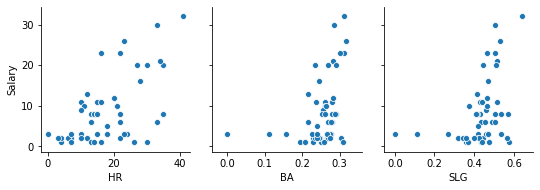

In [15]:
sns.pairplot(data=batting, y_vars=['Salary'], x_vars=['HR', 'BA', 'SLG'])

Create correlation heatmap

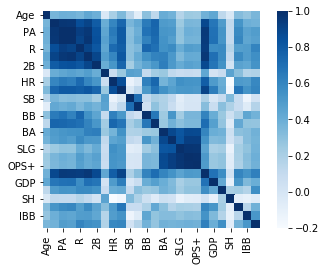

In [16]:
corrmat = batting.corr()
sns.heatmap(corrmat, square = True, cmap="Blues")

In [17]:
batting.corr()

,Age,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,Salary
Age,1.000000,0.364349,0.393124,0.387211,0.362734,0.431765,0.392214,-0.028756,0.206395,0.340377,0.141726,-0.071845,0.302985,0.125975,0.410031,0.379506,0.158864,0.251877,0.242527,0.383617,0.438304,0.128365,-0.020070,0.321309,0.280853,0.353163
G,0.364349,1.000000,0.967503,0.965843,0.860583,0.908184,0.794939,0.403410,0.601919,0.749000,0.358700,0.427436,0.654983,0.751378,0.498902,0.487293,0.250516,0.353874,0.347770,0.888568,0.673640,0.497680,0.117590,0.532532,0.392809,0.378014
PA,0.393124,0.967503,1.000000,0.995605,0.930851,0.962185,0.841225,0.442318,0.657535,0.805747,0.304971,0.395638,0.691567,0.745512,0.529290,0.512394,0.290142,0.389391,0.383875,0.949093,0.696817,0.536219,0.111345,0.579377,0.456689,0.488678
AB,0.387211,0.965843,0.995605,1.000000,0.910328,0.971982,0.853657,0.467734,0.629573,0.806858,0.316950,0.424555,0.623206,0.725776,0.540873,0.486615,0.282769,0.374618,0.368621,0.948288,0.701918,0.530450,0.104491,0.599743,0.442283,0.472554
R,0.362734,0.860583,0.930851,0.910328,1.000000,0.906803,0.818912,0.441263,0.727423,0.786945,0.304174,0.349348,0.749943,0.701585,0.548326,0.579351,0.403946,0.489389,0.478162,0.937065,0.569468,0.582021,0.159915,0.480035,0.491104,0.612983
H,0.431765,0.908184,0.962185,0.971982,0.906803,1.000000,0.899173,0.487735,0.600767,0.817818,0.300490,0.414982,0.547775,0.617033,0.626069,0.513947,0.338112,0.421359,0.413006,0.962212,0.704469,0.577954,0.113428,0.579916,0.497138,0.560628
2B,0.392214,0.794939,0.841225,0.853657,0.818912,0.899173,1.000000,0.404365,0.527789,0.752837,0.224363,0.373424,0.449263,0.524643,0.640399,0.509261,0.413157,0.468630,0.446506,0.883613,0.679867,0.546297,0.027062,0.461023,0.437311,0.541839
3B,-0.028756,0.403410,0.442318,0.467734,0.441263,0.487735,0.404365,1.000000,0.076864,0.260638,0.474416,0.459330,0.107046,0.229979,0.261497,0.117510,0.076818,0.095605,0.080668,0.432741,0.019730,0.086271,0.457035,0.311085,0.163170,0.178288
HR,0.206395,0.601919,0.657535,0.629573,0.727423,0.600767,0.527789,0.076864,1.000000,0.859332,-0.123085,-0.029606,0.630502,0.741760,0.369337,0.449476,0.556062,0.537974,0.532541,0.788446,0.497673,0.403960,-0.203106,0.505063,0.490861,0.594404
RBI,0.340377,0.749000,0.805747,0.806858,0.786945,0.817818,0.752837,0.260638,0.859332,1.000000,-0.021254,0.123699,0.516305,0.676645,0.548754,0.479007,0.518211,0.525237,0.510368,0.910452,0.646837,0.423119,-0.160107,0.672487,0.544121,0.607059


Run OLS linear regression

In [18]:
y=batting['Salary']
X=batting[['Age', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB']]
X=sm.add_constant(X)
model1 = sm.OLS(y, X) 
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     4.770
Date:                Wed, 27 Jan 2021   Prob (F-statistic):           4.16e-05
Time:                        12:08:42   Log-Likelihood:                -148.94
No. Observations:                  55   AIC:                             347.9
Df Residuals:                      30   BIC:                             398.1
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.7253     24.969     -0.349      0.729     -59.719      42.268
Age            0.5635      0.347      1.623      0.115      -0.145       1.272
G             -0.0538      0.098     -0.551      0.586      -0.253       0.146
PA            -1.0937      1.550     -0.706      0.486      -4.259       2.071
AB             1.0230      1.537      0.666      0.511      -2.115       4.161
R              0.0264      0.156      0.169      0.867      -0.293       0.345
H              0.0084      0.195      0.043      0.966      -0.389       0.406
2B            -0.0082      0.210     -0.039      0.969      -0.437       0.421
3B             0.3042      0.508      0.599      0.554      -0.733       1.342
HR            -0.1499      0.286     -0.525      0.604      -0.733       0.433
RBI            0.0570      0.108      0.528      0.601      -0.163       0.277
SB             0.0441      0.211      0.208      0.836      -0.388       0.476
CS             1.0744      0.545      1.970      0.058      -0.040       2.188
BB             1.1096      1.551      0.716      0.480      -2.057       4.276
SO            -0.0398      0.042     -0.941      0.354      -0.126       0.047
BA          -125.9739     96.252     -1.309      0.201    -322.547      70.600
OBP         -468.7665   1775.298     -0.264      0.794   -4094.409    3156.876
SLG         -542.1484   1781.678     -0.304      0.763   -4180.821    3096.524
OPS          548.5592   1807.228      0.304      0.764   -3142.292    4239.410
OPS+          -0.0084      0.234     -0.036      0.972      -0.487       0.470
TB             0.1587      0.107      1.478      0.150      -0.061       0.378
GDP            0.1241      0.221      0.562      0.578      -0.327       0.575
HBP            1.7457      1.594      1.095      0.282      -1.510       5.002
SH             0.7832      1.719      0.456      0.652      -2.727       4.294
SF             1.8623      1.510      1.234      0.227      -1.221       4.945
IBB            0.8110      0.477      1.701      0.099      -0.163       1.785
==============================================================================
Omnibus:                        7.802   Durbin-Watson:                   2.214
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                6.975
Skew:                          -0.819   Prob(JB):                       0.0306
Kurtosis:                       3.602   Cond. No.                     1.08e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.5e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Rerun with SH, SF, CS, 3B removed<br>
SB coefficient is very low but seems would be usefull<br>
Might be most undervalued stat

In [19]:
y=batting['Salary']
X=batting[['Age', 'G', 'PA', 'AB', 'R', 'H', '2B', 'HR', 'RBI', 'SB', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'HBP', 'IBB']]
X=sm.add_constant(X)
model1 = sm.OLS(y, X) 
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     4.606
Date:                Wed, 27 Jan 2021   Prob (F-statistic):           4.83e-05
Time:                        12:08:48   Log-Likelihood:                -154.52
No. Observations:                  55   AIC:                             353.0
Df Residuals:                      33   BIC:                             397.2
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4679     22.941      0.064      0.949     -45.206      48.142
Age            0.3096      0.345      0.899      0.375      -0.391       1.011
G             -0.1329      0.093     -1.423      0.164      -0.323       0.057
PA             0.1873      0.518      0.362      0.720      -0.866       1.241
AB            -0.2148      0.526     -0.408      0.686      -1.285       0.855
R             -0.0517      0.156     -0.331      0.743      -0.370       0.266
H             -0.0719      0.372     -0.194      0.848      -0.828       0.684
2B             0.0132      0.406      0.033      0.974      -0.814       0.840
HR            -0.2092      1.019     -0.205      0.839      -2.283       1.865
RBI            0.0916      0.113      0.813      0.422      -0.138       0.321
SB             0.3358      0.177      1.902      0.066      -0.023       0.695
BB            -0.2469      0.555     -0.445      0.659      -1.376       0.882
SO            -0.0453      0.043     -1.042      0.305      -0.134       0.043
BA          -157.6000     96.146     -1.639      0.111    -353.210      38.010
OBP          -24.2899   1756.566     -0.014      0.989   -3598.051    3549.471
SLG         -153.1875   1760.977     -0.087      0.931   -3735.922    3429.547
OPS          136.5066   1777.388      0.077      0.939   -3479.617    3752.630
OPS+           0.0318      0.222      0.143      0.887      -0.419       0.483
TB             0.2180      0.297      0.734      0.468      -0.386       0.822
GDP            0.0567      0.230      0.246      0.807      -0.412       0.525
HBP            0.4490      0.730      0.615      0.543      -1.036       1.934
IBB            0.8245      0.494      1.669      0.105      -0.181       1.830
==============================================================================
Omnibus:                        2.897   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.235   Jarque-Bera (JB):                2.158
Skew:                          -0.473   Prob(JB):                        0.340
Kurtosis:                       3.214   Cond. No.                     3.18e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.18e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Using the first regression add column to existing data with projected salary
- Add column for the difference between actual salary and rojected salary
- Add columns for the standard deviation in error between ProjSalary and actual Salary added to ProjSalary

In [24]:
batting["ProjSalary"] = 1.4679 + (0.3096*batting["Age"]) + (-0.1329*batting["G"]) + (0.1873*batting["PA"]) + (-0.2148*batting["AB"]) + (-0.0517*batting["R"]) + (-0.0719*batting["H"]) + (0.0132*batting["2B"]) + (-0.2092*batting["HR"]) + (0.0916*batting["RBI"]) + (0.3358*batting["SB"]) + (-0.2469*batting["BB"]) + (-0.0453*batting["SO"]) + (-157.6000*batting["BA"]) + (-24.2899*batting["OBP"]) + (-153.1875*batting["SLG"]) + (136.5066*batting["OPS"]) + (0.0318*batting["OPS+"]) + (0.2180*batting["TB"]) + (0.0567*batting["GDP"]) + (0.4490*batting["HBP"]) + (0.8245*batting["IBB"])
batting["Diff"] = batting["Salary"] - batting["ProjSalary"]
batting["+1Std"] = batting["ProjSalary"] + np.std(batting["Diff"]) 
batting["-1Std"] = batting["ProjSalary"] - np.std(batting["Diff"])
batting = batting[["Name", "Salary", "+1Std", "ProjSalary", "-1Std", "Diff", "Age", "G", "PA", "AB", "R", "H", "2B", "3B", "HR", "RBI", "SB", "CS", "BB", "SO", "BA", "OBP", "SLG", "OPS", "OPS+", "TB", "GDP", "HBP", "SH", "SF", "IBB"]]
batting


,Name,Salary,+1Std,ProjSalary,-1Std,Diff,Age,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB
0,Jose Abreu,30,28.112035,24.094925,20.077815,5.905075,32.0,159.0,693.0,634.0,85.0,180.0,38.0,1.0,33.0,123.0,2.0,2.0,36.0,152.0,0.284,0.330,0.503,0.834,118.0,319.0,24.0,13.0,0.0,10.0,4.0
7,Michael Brantley,23,21.855229,17.838120,13.821010,5.161880,32.0,148.0,637.0,575.0,88.0,179.0,40.0,2.0,22.0,90.0,3.0,2.0,51.0,66.0,0.311,0.372,0.503,0.875,126.0,289.0,21.0,7.0,0.0,4.0,3.0
8,Ryan Braun,8,18.738990,14.721880,10.704771,-6.721880,35.0,144.0,508.0,459.0,70.0,131.0,31.0,2.0,22.0,75.0,11.0,1.0,34.0,105.0,0.285,0.343,0.505,0.849,116.0,232.0,15.0,8.0,0.0,3.0,1.0
11,Byron Buxton,11,11.805352,7.788242,3.771132,3.211758,25.0,87.0,295.0,271.0,48.0,71.0,30.0,4.0,10.0,46.0,14.0,3.0,19.0,68.0,0.262,0.314,0.513,0.827,115.0,139.0,3.0,2.0,2.0,1.0,1.0
12,Lorenzo Cain,10,9.931942,5.914833,1.897723,4.085167,33.0,148.0,623.0,562.0,75.0,146.0,30.0,0.0,11.0,48.0,18.0,8.0,50.0,106.0,0.260,0.325,0.372,0.697,81.0,209.0,14.0,6.0,0.0,4.0,0.0
13,Robinson Cano,8,12.376918,8.359808,4.342699,-0.359808,36.0,107.0,423.0,390.0,46.0,100.0,28.0,0.0,13.0,39.0,0.0,0.0,25.0,69.0,0.256,0.307,0.428,0.736,95.0,167.0,16.0,5.0,0.0,3.0,3.0
14,Starlin Castro,6,10.951347,6.934238,2.917128,-0.934238,29.0,162.0,676.0,636.0,68.0,172.0,31.0,4.0,22.0,86.0,2.0,2.0,28.0,111.0,0.270,0.300,0.436,0.736,93.0,277.0,23.0,3.0,0.0,9.0,2.0
18,Nelson Cruz,32,32.349861,28.332751,24.315642,3.667249,38.0,120.0,521.0,454.0,81.0,141.0,26.0,0.0,41.0,108.0,0.0,1.0,56.0,131.0,0.311,0.392,0.639,1.031,168.0,290.0,14.0,7.0,0.0,3.0,8.0
19,Travis d'Arnaud,1,6.949690,2.932581,-1.084529,-1.932581,30.0,103.0,391.0,351.0,52.0,88.0,16.0,0.0,16.0,69.0,0.0,1.0,32.0,85.0,0.251,0.312,0.433,0.745,98.0,152.0,4.0,2.0,0.0,6.0,0.0
24,Paul DeJong,20,17.362101,13.344991,9.327881,6.655009,25.0,159.0,664.0,583.0,97.0,136.0,31.0,1.0,30.0,78.0,9.0,5.0,62.0,149.0,0.233,0.318,0.444,0.762,99.0,259.0,15.0,13.0,0.0,6.0,1.0
